# Predict recorded states

Predict recorded states and compare to future states. This might be usefull to determine the state the robot is in:
- The wheels of the robot are either blocked
- Or they can roll freely

## Prepare the data
### Import all the stuff in use

In [1]:
import pickle
import pandas as pd
import numpy as np
import tqdm

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.multioutput import MultiOutputRegressor

### Check that every thing that is used is available in the current folder

In [4]:
!ls

analyse_states.ipynb	regressor_a_matrix.pkl	       states_open.csv
create_models.ipynb	regressor_gains.pkl	       videte_wheel.ipynb
params_a_matrixs_f.pkl	regressor_selection_gains.pkl  visualization.ipynb


### Read the recorded files into pandas (ros2 bag as csv)

In [5]:
df = pd.read_csv("states_open.csv")

df

,sec,nsec,frame_id,x1,x2,x3,x4,x5,x6,w1,...,w4,w5,w6,k1,k2,k3,k4,k5,k6,u
0,1600892364,11113280,robot,0.151688,-0.002232,0.017458,0.003468,-185.334625,0.0,0.1415,...,0.0,-183.822894,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,-0.002642
1,1600892364,15923534,robot,0.151735,0.001789,0.017458,0.003468,-185.334625,0.0,0.1415,...,0.0,-183.822894,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,0.012995
2,1600892364,20032963,robot,0.151735,0.001789,0.017124,-0.011715,-185.334625,0.0,0.1415,...,0.0,-183.822894,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,0.005031
3,1600892364,22898667,robot,0.151735,0.001789,0.017124,-0.011715,-185.334625,0.0,0.1415,...,0.0,-183.822894,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,0.005031
4,1600892364,28661242,robot,0.151789,0.000776,0.017124,-0.011715,-185.334625,0.0,0.1415,...,0.0,-183.822894,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,0.003587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30951,1600892455,391213348,robot,0.155436,-0.004590,-0.020278,0.002978,-180.897766,0.0,0.1415,...,0.0,-178.691134,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,-0.039909
30952,1600892455,393460227,robot,0.155436,-0.004590,-0.020278,0.002978,-180.897766,0.0,0.1415,...,0.0,-178.691134,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,-0.039909
30953,1600892455,395996733,robot,0.155407,0.000541,-0.020278,0.002978,-180.897766,0.0,0.1415,...,0.0,-178.691134,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,-0.023320
30954,1600892455,398442017,robot,0.155407,0.000541,-0.020278,0.002978,-180.897766,0.0,0.1415,...,0.0,-178.691134,-0.0,-470.750654,-43.111772,1.323642,-6.585464,-3.130495,-5.313367,-0.023320


### Have a short look into the data

&lt;Figure size 432x288 with 0 Axes&gt;

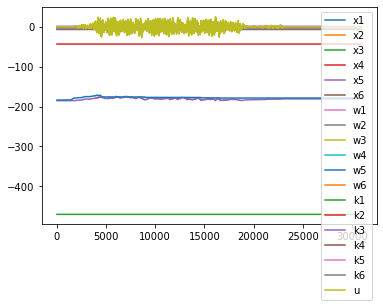

In [6]:
plt.figure();
df.loc[:, 'x1': 'u'].plot();

### Extract robot states from the recording

In [7]:
states = df.loc[:, 'x1': 'x6']

states

,x1,x2,x3,x4,x5,x6
0,0.151688,-0.002232,0.017458,0.003468,-185.334625,0.0
1,0.151735,0.001789,0.017458,0.003468,-185.334625,0.0
2,0.151735,0.001789,0.017124,-0.011715,-185.334625,0.0
3,0.151735,0.001789,0.017124,-0.011715,-185.334625,0.0
4,0.151789,0.000776,0.017124,-0.011715,-185.334625,0.0
...,...,...,...,...,...,...
30951,0.155436,-0.004590,-0.020278,0.002978,-180.897766,0.0
30952,0.155436,-0.004590,-0.020278,0.002978,-180.897766,0.0
30953,0.155407,0.000541,-0.020278,0.002978,-180.897766,0.0
30954,0.155407,0.000541,-0.020278,0.002978,-180.897766,0.0


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f33b1bc2c70&gt;

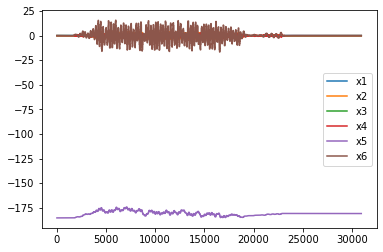

In [8]:
states.plot()

### Extract target states

In [9]:
target = df.loc[:, 'w1': 'w6']

target

,w1,w2,w3,w4,w5,w6
0,0.1415,0.0,0.0,0.0,-183.822894,-0.0
1,0.1415,0.0,0.0,0.0,-183.822894,-0.0
2,0.1415,0.0,0.0,0.0,-183.822894,-0.0
3,0.1415,0.0,0.0,0.0,-183.822894,-0.0
4,0.1415,0.0,0.0,0.0,-183.822894,-0.0
...,...,...,...,...,...,...
30951,0.1415,0.0,0.0,0.0,-178.691134,-0.0
30952,0.1415,0.0,0.0,0.0,-178.691134,-0.0
30953,0.1415,0.0,0.0,0.0,-178.691134,-0.0
30954,0.1415,0.0,0.0,0.0,-178.691134,-0.0


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f33b1ae75e0&gt;

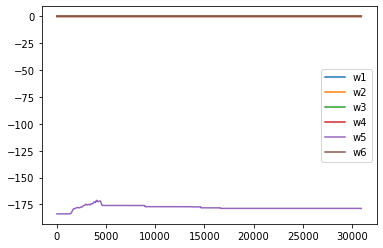

In [10]:
target.plot()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f33b1ae6310&gt;

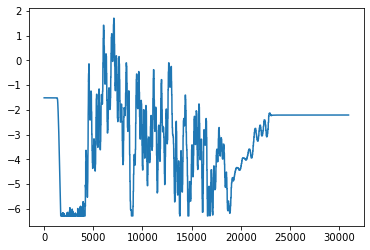

In [11]:
(states['x5'] - target['w5']).plot()

### Get control inputs of the robot

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f33b19ee850&gt;

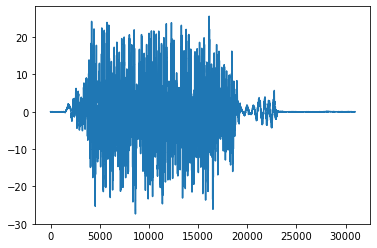

In [12]:
control = df['u']

control.plot()

### Load regressors for A matrix and gains

In [13]:
pkl_filename = "regressor_a_matrix.pkl"
a_matrix = pd.read_pickle(pkl_filename)

In [14]:
pkl_filename = "regressor_gains.pkl"
gains = pd.read_pickle(pkl_filename)

In [15]:
A_open = a_matrix.predict([[0,0,0,0,0,0,0]]).reshape(6,6)
A_closed = a_matrix.predict([[0,0,0,0,0,0,200]]).reshape(6,6)

A_open - A_closed

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.42108547e-13,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.26325641e-14,
         2.35269419e+02,  0.00000000e+00, -9.38506425e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.94536137e+02,  0.00000000e+00,  7.76018470e+01]])

### Copied B vector from robot

In [16]:
B = [0.0, -134.30029546065, 0.0, 219.351159270877, 0.0, 511.649622338623]

## Predict the recorded data
### Try to predict single step
#### Predict for open aka free rolling wheels

In [17]:
control[0]

-0.002642095321789384

In [18]:
x_dot = A_open @ np.array(states.iloc[0]) + np.array(B) * control[0]

x_dot * 0.08

array([-1.78541669e-04,  1.48015026e+00,  2.77432000e-04, -2.05733290e-01,
        0.00000000e+00, -1.08146166e-01])

In [19]:
states.iloc[0] + x_dot * 0.08

x1      0.151509
x2      1.477918
x3      0.017735
x4     -0.202265
x5   -185.334625
x6     -0.108146
Name: 0, dtype: float64

#### Predict for closed aka blocked wheels

In [20]:
x_dot = A_closed @ np.array(states.iloc[0]) + np.array(B) * control[0]

x_dot * 0.08

array([-1.78541669e-04,  1.48015026e+00,  2.77432000e-04, -2.71004556e-01,
        0.00000000e+00, -5.41756164e-02])

In [21]:
states.iloc[0] + x_dot * 0.08

x1      0.151509
x2      1.477918
x3      0.017735
x4     -0.267537
x5   -185.334625
x6     -0.054176
Name: 0, dtype: float64

### Predict multiple steps

In [22]:
def predict(states_to_predict, control_local, A_local, B_local, step = 0):
    prediction = []
    lines = len(states)
    for i in range(lines):
        # At end of control inputs list use last entry
        if (i + step < lines):
            control_position = i + step
        else:
            control_position = lines - 1
        prediction.append(states_to_predict.iloc[i] + (A_local @ np.array(states_to_predict.iloc[i]) + np.array(B_local) * control_local[control_position]) * 0.08)
    return pd.DataFrame(prediction)

In [23]:
def multi_predict(states_to_predict, control_local, A_local, B_local, steps):
    predictions = []
    predictions.append(states_to_predict)
    for step in range(steps):
        predictions.append(predict(predictions[step], control_local, A_local, B_local, step))
    return predictions

In [24]:
predictions_open = multi_predict(states, control, A_open, B, 4)

predictions_open

[             x1        x2        x3        x4          x5   x6
 0      0.151688 -0.002232  0.017458  0.003468 -185.334625  0.0
 1      0.151735  0.001789  0.017458  0.003468 -185.334625  0.0
 2      0.151735  0.001789  0.017124 -0.011715 -185.334625  0.0
 3      0.151735  0.001789  0.017124 -0.011715 -185.334625  0.0
 4      0.151789  0.000776  0.017124 -0.011715 -185.334625  0.0
 ...         ...       ...       ...       ...         ...  ...
 30951  0.155436 -0.004590 -0.020278  0.002978 -180.897766  0.0
 30952  0.155436 -0.004590 -0.020278  0.002978 -180.897766  0.0
 30953  0.155407  0.000541 -0.020278  0.002978 -180.897766  0.0
 30954  0.155407  0.000541 -0.020278  0.002978 -180.897766  0.0
 30955  0.155407  0.000541 -0.020278  0.002978 -180.897766  0.0
 
 [30956 rows x 6 columns],
              x1        x2        x3        x4          x5        x6
 0      0.151509  1.477918  0.017735 -0.202265 -185.334625 -0.108146
 1      0.151878  1.314387  0.017735  0.072130 -185.334625  0.531

In [25]:
predictions_closed = multi_predict(states, control, A_closed, B, 4)

predictions_closed

[             x1        x2        x3        x4          x5   x6
 0      0.151688 -0.002232  0.017458  0.003468 -185.334625  0.0
 1      0.151735  0.001789  0.017458  0.003468 -185.334625  0.0
 2      0.151735  0.001789  0.017124 -0.011715 -185.334625  0.0
 3      0.151735  0.001789  0.017124 -0.011715 -185.334625  0.0
 4      0.151789  0.000776  0.017124 -0.011715 -185.334625  0.0
 ...         ...       ...       ...       ...         ...  ...
 30951  0.155436 -0.004590 -0.020278  0.002978 -180.897766  0.0
 30952  0.155436 -0.004590 -0.020278  0.002978 -180.897766  0.0
 30953  0.155407  0.000541 -0.020278  0.002978 -180.897766  0.0
 30954  0.155407  0.000541 -0.020278  0.002978 -180.897766  0.0
 30955  0.155407  0.000541 -0.020278  0.002978 -180.897766  0.0
 
 [30956 rows x 6 columns],
              x1        x2        x3        x4          x5        x6
 0      0.151509  1.477918  0.017735 -0.267537 -185.334625 -0.054176
 1      0.151878  1.314387  0.017735  0.006858 -185.334625  0.585

## Compare predictions to recorded states
### Compare open wheels predictions with recorded states

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f33b02cd5b0&gt;

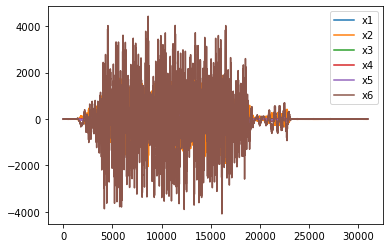

In [26]:
compare = []

prediction_open = predictions_open[4]

for i in range(len(states) - 4):
    compare.append(states.iloc[i+4] - prediction_open.iloc[i])

compare_open = pd.DataFrame(compare)
compare_open.plot()

### Compare closed wheels predictions with recorded states

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f33b01ee4f0&gt;

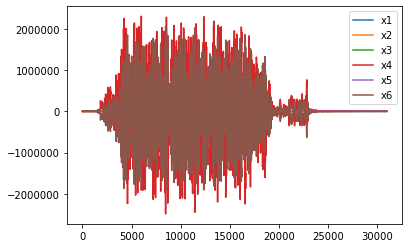

In [27]:
compare = []

prediction_closed = predictions_closed[4]

for i in range(len(states) - 4):
    compare.append(states.iloc[i+4] - prediction_closed.iloc[i])

compare_closed = pd.DataFrame(compare)

compare_closed.plot()

### Show mean and std of both diffs

In [28]:
print("Open")
print("----\nmean:")
print(compare_open.mean())
print("\nstd:")
print(compare_open.std())

print()

print("Closed")
print("------\nmean:")
print(compare_closed.mean())
print("\nstd:")
print(compare_closed.std())

Open
----
mean:
x1   -0.506848
x2   -6.611214
x3   -0.482751
x4   -1.240732
x5   -1.130431
x6   -9.241550
dtype: float64

std:
x1      38.068208
x2     494.119052
x3      48.465126
x4     132.478096
x5     130.270023
x6    1070.716984
dtype: float64

Closed
------
mean:
x1      -0.506848
x2      -6.611214
x3     -30.606095
x4    9421.978711
x5      23.803689
x6   -7810.397846
dtype: float64

std:
x1        38.068208
x2       494.119052
x3      2223.689589
x4    685110.802226
x5      1738.681665
x6    567839.171751
dtype: float64
